In [8]:
!pip install hazm

  Obtaining dependency information for hazm from https://files.pythonhosted.org/packages/6a/06/302d69a49f0ea8d5700341fcd5f0630361fe7d8cf17254ff45702ecf6058/hazm-0.9.4-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 73.6 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 70.6 MB/s eta 0:00:00
  Obtaining dependency information for python-crfsuite<0.10.0,>=0.9.9 from https://files.pythonhosted.org/packages/38/1d/c475ba7d11e9735f00eb08e2f5315aa2e21c24cc85a0474c3fd425edef58/python_crfsuite-0.9.10-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.7/371.7 kB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 68.8 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into ac

In [9]:
import hazm 
from transformers import GPT2LMHeadModel, GPT2Tokenizer,AdamW
from transformers import AutoTokenizer, AutoConfig, AutoModelWithLMHead
from transformers import AutoTokenizer, GPT2LMHeadModel, GPT2Config
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn.functional as F

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
# Load the pre-trained GPT-2 model and tokenizer
model_name = "HooshvareLab/gpt2-fa"
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name, padding_side = 'left')
tokenizer.add_special_tokens({'pad_token': ''})  
tokenizer.pad_token = ''
normalizer = hazm.Normalizer(persian_numbers=False)
model.to(device)

config.json:   0%|          | 0.00/808 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/485M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/728 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/875k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/14.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/104 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.75M [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(42001, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=42001, bias=False)
)

In [12]:
file_path = '/kaggle/input/ferdosi/ferdousi.txt'          
with open(file_path, 'r') as file:
    lines = file.readlines()[2:]
len(lines)
inputs = []
outputs = []
for i in range(len(lines)): 
    if i%4 == 1 :
        inp = lines[i-1].replace("\n", " ") + lines[i].replace("\n", " ") 
        inputs.append( normalizer.normalize(inp) )
    if i%4 == 3 :
        out = lines[i-1].replace("\n", " ") + lines[i].replace("\n", " ")
        outputs.append( normalizer.normalize(out) )

In [13]:
tokenized_inputs = tokenizer(inputs, padding=True, truncation=True, return_tensors="pt")
tokenized_outputs = tokenizer(outputs, padding=True, truncation=True, return_tensors="pt")

In [14]:
# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, input_sequences, output_sequences, train = True):
        if train :
            self.input_sequences = input_sequences['input_ids'][: int(len(input_sequences['input_ids']) * 0.8)]
            self.input_attentions = input_sequences['attention_mask'][: int(len(input_sequences['input_ids']) * 0.8)]
            self.output_sequences = output_sequences['input_ids'][: int(len(input_sequences['input_ids']) * 0.8)]
        if not train:
            self.input_sequences = input_sequences['input_ids'][int(len(input_sequences['input_ids']) * 0.8) : ]
            self.input_attentions = input_sequences['attention_mask'][int(len(input_sequences['input_ids']) * 0.8) : ]
            self.output_sequences = output_sequences['input_ids'][int(len(input_sequences['input_ids']) * 0.8) : ]
            
    def __len__(self):
        return len(self.input_sequences)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_sequences[idx],
            'attention_mask': self.input_attentions[idx],
            'labels': self.output_sequences[idx]
        }


# Create instances of the custom dataset
dataset_train = CustomDataset(tokenized_inputs, tokenized_outputs, train = True)
dataset_test = CustomDataset(tokenized_inputs, tokenized_outputs, train = False)

# Define your data loader
batch_size = 4
train_loader = DataLoader(dataset_train, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size = batch_size, shuffle=True)



In [15]:
for batch in train_loader: 
    print(batch)
    break

{'input_ids': tensor([[    5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
             5, 28016,   287,   330,  5198, 26339,   437, 10280,  6308,   395,
          3846,   718],
        [    5,     5,     5,     5,     5,  8033,   730,  2005,   287, 17772,
           285,   448,   323,   314, 13614,   293,  1234,   293, 27963,   472,
           285,   448],
        [    5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
             5,     5,   286,  9415, 15676,   586,  1677, 25754,   274,   312,
          1023,  4076],
        [    5,     5,     5,     5,     5,     5,     5,     5,     5,   286,
           640,   384, 12959,   521,  5875, 29976,  4540,   561,   451,   858,
          6414,  1546]]), 'attention_mask': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0

In [16]:
import gc
torch.cuda.empty_cache()
# del model, org_image, changed_image, labels

gc.collect()

0

### Previous result of the model 

In [17]:
# Function to generate responses
def generate_response(batch):
    input_ids = batch['input_ids'].to(device)
    labels = batch['labels'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    # Generate response
    output_sequences = model.generate(
        input_ids=input_ids,
        max_length=44,
        num_return_sequences=1,
#         no_repeat_ngram_size=2,
#         temperature=0.7,
#         top_p=0.9,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
        attention_mask= attention_mask
    )

    # Decode the generated responses
    responses = []
    for response_id in output_sequences:
        response = tokenizer.decode(response_id, skip_special_tokens=True)
        responses.append(response)

    return responses

responses = generate_response(batch)
for response in responses:
    print('\n\n', response)




 برادرش را خواند فرشیدورد سپاهی برون کرد مردان مرد و زنان و زنان و مردان و زنان و مردان و زنان و مردان و زنان و مردان و زنان و مردان


 همه زیر فرمانش بیچاره‌اند که با سوزش و جنگ و پتیاره‌اند. از این‌ها که بگذریم، این‌ها همه‌ی آن‌ها هستند که به‌خاطر


 ز گفتار دهقان یکی داستان بپیوندم از گفته باستان‌شناسان و تاریخ‌نویسان است که در آن به بررسی تاریخ و فرهنگ ایران باستان و تاریخ آن پرداخته‌


 زره دار گردی بیامد دلیر کجا نام اوبود پیروز شیرویه دار و بیامد شیرویه دار و بیامد شیرویه دار و بیامد شیرویه دار و بی


In [18]:
learning_rate = 1e-6
optimizer = AdamW(model.parameters(), lr=learning_rate)
epoch_number = 5
train_losses = []
valid_losses = []
for epoch_num in range(epoch_number): 
    model.eval()
    eval_loss = 0
    for idx, batch in enumerate(test_loader): 
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        generated_output = model(
            input_ids = input_ids,
            attention_mask = attention_mask,
            labels = labels )  
        loss = generated_output[0]
        eval_loss += loss.item()
    print(f"Avreage evaluation loss for {epoch_num + 1 }th epoch = " , eval_loss/idx )
    valid_losses.append(eval_loss/idx)
    model.train()
    total_loss = 0
    for idx, batch in enumerate(train_loader): 
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        generated_output = model(
            input_ids = input_ids,
            attention_mask = attention_mask,
            labels = labels )        
        loss = generated_output[0]
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if idx%100 ==0: 
            print(f" loss for the {idx +1}th batch  = " , loss.item() )
    print(f"Avreage train loss for {epoch_num + 1 }th epoch = " , total_loss/idx )
    train_losses.append(total_loss/idx)

    

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Avreage evaluation loss for 1th epoch =  13.830471987878123
 loss for the 1th batch  =  13.811408996582031
 loss for the 101th batch  =  12.000876426696777
 loss for the 201th batch  =  10.206310272216797
 loss for the 301th batch  =  9.012651443481445
 loss for the 401th batch  =  6.790555000305176
 loss for the 501th batch  =  6.594540596008301
 loss for the 601th batch  =  6.55123233795166
 loss for the 701th batch  =  5.537768363952637
 loss for the 801th batch  =  5.538773536682129
 loss for the 901th batch  =  6.689272880554199
 loss for the 1001th batch  =  5.356339931488037
 loss for the 1101th batch  =  5.984127521514893
 loss for the 1201th batch  =  5.513629913330078
 loss for the 1301th batch  =  5.5159382820129395
 loss for the 1401th batch  =  5.309263229370117
 loss for the 1501th batch  =  5.694962024688721
 loss for the 1601th batch  =  5.286073684692383
 loss for the 1701th batch  =  5.540404319763184
 loss for the 1801th batch  =  5.40868616104126
 loss for the 1901t

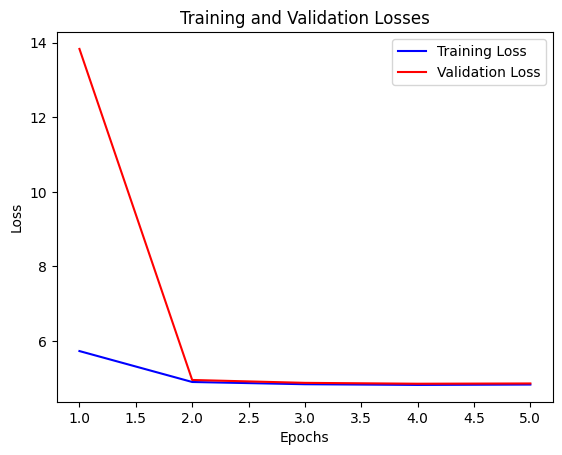

In [19]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Training Loss')
plt.plot(range(1, len(train_losses) + 1), valid_losses, 'r-', label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show plot
plt.show()

In [27]:
# Function to generate responses
test_loader = DataLoader(dataset_test, batch_size = 16, shuffle=True)
for batch in test_loader: 
    break
def generate_response(batch):
    input_ids = batch['input_ids'].to(device)
    labels = batch['labels'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    # Generate response
    output_sequences = model.generate(
        input_ids=input_ids,
        max_length=44,
        num_return_sequences=1,
        no_repeat_ngram_size=1,
        temperature=0.1,
        top_p=0.9,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
        attention_mask= attention_mask
    )

    # Decode the generated responses
    responses = []
    for response_id in output_sequences:
        response = tokenizer.decode(response_id, skip_special_tokens=True)
        responses.append(response)

    return responses

responses = generate_response(batch)
for response in responses:
    print('\n\n', response)




 بپیچید و بر زد یکی سرد باد به زاری بران جامه بر جان بداد ز از گفت چوست که را‌ اندر او همی شد آن شاه بود با سر پر آمد جهان بچو


 اگر شهریاری تو چندین دروغ بگویی نگیری بگیتی فروغ و بر به ز از را که‌گر شد همی باست بدان چو دل جهان من شاه بود آن


 بمارد چنین گفت کز مهتری همی از پی گو کنی داوری و به را ز بر‌ست کهان با آن شاه جهان تو سر بود در چو اندر شد او داد


 چو برتخت بنشست و کرد آفرین ز نیکی دهش بر جهان‌آفرین به از که با را شاه همی چو شد گفت بودانید ب رزم او دل بدم سپاه تو باد


 شد آیین گشسب اندران چاره جوی که آن کار را چون دهد رنگ وبوی و به از ز بر‌ با اندر شد شاه کرد گفت تا در پیش او بود تو همیست ب چو


 از اندازه بر نگذرانی سخن که تو نو به کاری گیتی کهن و از‌ ز را با بدست همی شد آن اندر گفت او بود شاه جهان آمد دل در من چو


 همه کارهای شما ایزدیست زمردی و ز دانش و بخردیست که از به‌گر بر همی شد اندر را ب با بود تاش بد چو بی او شاهم کرد


 زمانی همی گفت برساوه شاه چه سود آمد ازجادویی برسپاه و به را بر که زش‌ست اندر شد کرد با بود تو سر ب او در چو آن آید


 بگوید تو را زاد فرخ همین

In [28]:
for batch in test_loader: 
    input_ids = batch['input_ids'].to(device)
    labels = batch['labels'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    break
    
output_sequences = model.generate(
    input_ids=input_ids,
    max_length=44,
    num_return_sequences=1,
    no_repeat_ngram_size=1,
    temperature=0.1,
    top_p=0.9,
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id,
    attention_mask= attention_mask
)  
output_sequences.shape

torch.Size([16, 44])

In [22]:
output_sequences[:,22:]


tensor([[  293,   312,   323,   327,   330,   285,   296,   314, 16477,   403,
           639,   716,   412,   395, 15233,   526,   390, 13052,   449,  1215,
          1088,  2199],
        [  293,   312,   323,   355,   303,   330,   285,   526,   390,   288,
          1215,   314,   639, 15233,   296,   287,   298,   412, 16477,   451,
           358,   403],
        [  293,   323,   303,   355,   327,   312,   285, 16477,   296,   314,
           451, 15233,   403,   399,   395,   287,   526,   390,   288,  1215,
          1088,   449],
        [  293,   312,   330,   303,   327,   355,   526,   403,   314, 15233,
           296, 16477,   639,   288,  1215,   390,   451,   358,   298,  2199,
         13052,   995],
        [  312,   323,   355,   330,   358,   285,   296,   395,   322,   403,
           390,   639,   526,   662, 16477, 13052,   279,   378,   287,  1215,
           484,   449],
        [  293,   323,   303,   330,   312,   285,   355,   296, 15233,   314,
           

In [29]:
label_seqs = []
output_seqs = []

for response_id in output_sequences:
    output_seq = tokenizer.decode(response_id[22:] , skip_special_tokens=True)
    output_seqs.append(output_seq)

for label in labels:
    label_seq = tokenizer.decode(label , skip_special_tokens=True)
    label_seqs.append(label_seq)

In [25]:
!pip install rouge


Recall-Oriented Understudy for Gisting Evaluation 

In [34]:
from rouge import Rouge

def calculate_rouge_scores(candidate, reference):
    rouge = Rouge()
    scores = rouge.get_scores(candidate, reference)
    return scores

# Example reference and candidate sentences
reference = 'Reference sentence for evaluation.'
candidate = 'Generated sentence for evaluation.'

# Calculate ROUGE scores
rouge_scores = calculate_rouge_scores(output_seqs, label_seqs)

# Print ROUGE scores
print(rouge_scores[0]['rouge-1'])

{'r': 0.21428571428571427, 'p': 0.15789473684210525, 'f': 0.18181817693296617}
